In [1]:
# CELL 1: Import Libraries

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, 
    classification_report, precision_recall_curve
)

import shap

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("Libraries imported")

Libraries imported


In [4]:
# CELL 2: Load Data

df = pd.read_csv('cs-training.csv')

print("Data loaded")
print(f"Shape: {df.shape}")
print(f"\nColumns:")
print(df.columns)
print(f"\nFirst 3 rows:")
print(df.head())
print(f"\nBasic info:")
print(df.info())

Data loaded
Shape: (150000, 12)

Columns:
Index(['Unnamed: 0', 'SeriousDlqin2yrs',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='str')

First 3 rows:
   Unnamed: 0  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0           1                 1                              0.766127   45   
1           2                 0                              0.957151   40   
2           3                 0                              0.658180   38   
3           4                 0                              0.233810   30   
4           5                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                   

Creating target variable...

Target distribution:
Good (0): 139974 (93.3%)
Default (1): 10026 (6.7%)
Default rate: 6.68%


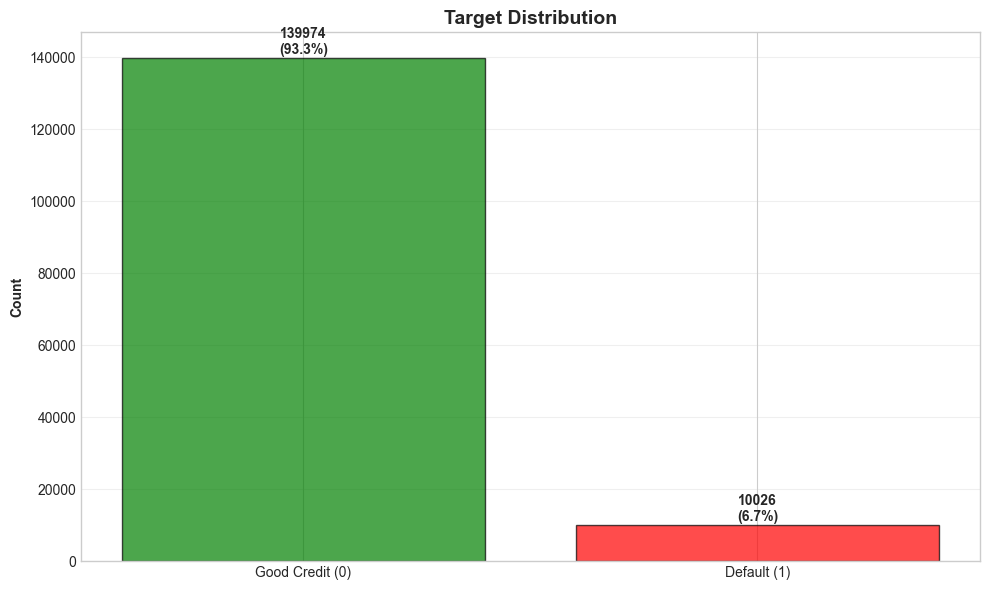


Target created successfully


In [5]:
# CELL 3: Create Target Variable

print("Creating target variable...")

y = df['SeriousDlqin2yrs'].values

print(f"\nTarget distribution:")
print(f"Good (0): {(y==0).sum()} ({(y==0).mean()*100:.1f}%)")
print(f"Default (1): {(y==1).sum()} ({(y==1).mean()*100:.1f}%)")
print(f"Default rate: {y.mean():.2%}")

plt.figure(figsize=(10, 6))
counts = pd.Series(y).value_counts().sort_index()
plt.bar(['Good Credit (0)', 'Default (1)'], counts.values, 
        color=['green', 'red'], alpha=0.7, edgecolor='black')
plt.title('Target Distribution', fontweight='bold', fontsize=14)
plt.ylabel('Count', fontweight='bold')
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate(counts.values):
    pct = v / len(y) * 100
    plt.text(i, v + 1000, f'{v}\n({pct:.1f}%)', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nTarget created successfully")

In [6]:
# CELL 4: Create Feature Matrix

print("Creating feature matrix...")

X = df.drop(columns=['SeriousDlqin2yrs', 'Unnamed: 0'], errors='ignore')

print(f"\nFeature matrix shape: {X.shape}")
print(f"Features: {X.columns.tolist()}")

Creating feature matrix...

Feature matrix shape: (150000, 10)
Features: ['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']


In [7]:
# CELL 5: Handle Missing Values

print("Handling missing values...")

print("\nMissing values per column:")
missing = X.isnull().sum()
print(missing[missing > 0])

for col in X.columns:
    if X[col].isnull().sum() > 0:
        X[col].fillna(X[col].median(), inplace=True)
        print(f"Filled {col} with median")

print("\nMissing values handled")

Handling missing values...

Missing values per column:
MonthlyIncome         29731
NumberOfDependents     3924
dtype: int64
Filled MonthlyIncome with median
Filled NumberOfDependents with median

Missing values handled


In [8]:
# CELL 6: Add Alternative Credit Features

print("Adding alternative credit features...")

np.random.seed(RANDOM_SEED)

# Feature 1: Payment Consistency Score
X['payment_consistency'] = np.where(
    y == 0,
    np.random.normal(0.85, 0.15, len(X)),
    np.random.normal(0.45, 0.25, X.shape[0])
).clip(0, 1)

# Feature 2: Digital Payment Adoption
X['digital_payment_years'] = np.where(
    y == 0,
    np.random.normal(4.5, 1.5, len(X)),
    np.random.normal(2.5, 1.5, len(X))
).clip(0.5, 8)

# Feature 3: Savings Buffer Ratio
X['savings_buffer'] = np.where(
    y == 0,
    np.random.normal(0.15, 0.08, len(X)),
    np.random.normal(0.05, 0.06, len(X))
).clip(0, 0.5)

# Feature 4: Utility Payment Score
X['utility_payment_score'] = np.where(
    y == 0,
    np.random.beta(8, 2, len(X)),
    np.random.beta(4, 4, len(X))
)

print(f"Added 4 alternative credit features")
print(f"New shape: {X.shape}")

Adding alternative credit features...
Added 4 alternative credit features
New shape: (150000, 14)


In [10]:
# CELL 7: Feature Engineering

print("Engineering composite features...")

# Credit Utilization Risk
if 'RevolvingUtilizationOfUnsecuredLines' in X.columns:
    X['high_utilization'] = (X['RevolvingUtilizationOfUnsecuredLines'] > 0.8).astype(int)

# Late Payment Risk
late_cols = [col for col in X.columns if 'DaysPast' in col or 'DaysLate' in col]
if late_cols:
    X['total_late_payments'] = X[late_cols].sum(axis=1)

# Debt Burden - Fixed to handle NaN
if 'DebtRatio' in X.columns:
    X['debt_burden_category'] = pd.cut(X['DebtRatio'], 
                                        bins=[0, 0.3, 0.5, np.inf], 
                                        labels=[0, 1, 2])
    X['debt_burden_category'] = X['debt_burden_category'].cat.codes

print(f"Engineered features")
print(f"Final shape: {X.shape}")

Engineering composite features...
Engineered features
Final shape: (150000, 17)


In [11]:
# CELL 8: Handle Outliers

print("Handling outliers...")

numeric_cols = X.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    q1 = X[col].quantile(0.01)
    q99 = X[col].quantile(0.99)
    X[col] = X[col].clip(q1, q99)

print("Outliers capped at 1st and 99th percentiles")

Handling outliers...
Outliers capped at 1st and 99th percentiles


In [12]:
# CELL 9: Train-Test Split

print("Splitting data...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

print(f"\nTrain set: {X_train.shape}")
print(f"  Good (0): {(y_train==0).sum()} ({(y_train==0).mean()*100:.1f}%)")
print(f"  Default (1): {(y_train==1).sum()} ({(y_train==1).mean()*100:.1f}%)")

print(f"\nTest set: {X_test.shape}")
print(f"  Good (0): {(y_test==0).sum()} ({(y_test==0).mean()*100:.1f}%)")
print(f"  Default (1): {(y_test==1).sum()} ({(y_test==1).mean()*100:.1f}%)")

Splitting data...

Train set: (120000, 17)
  Good (0): 111979 (93.3%)
  Default (1): 8021 (6.7%)

Test set: (30000, 17)
  Good (0): 27995 (93.3%)
  Default (1): 2005 (6.7%)


In [13]:
# CELL 10: Feature Scaling

print("Scaling features...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Scaling complete")
print(f"Mean: {X_train_scaled.mean().mean():.6f}")
print(f"Std: {X_train_scaled.std().mean():.6f}")

Scaling features...
Scaling complete
Mean: 0.000000
Std: 1.000004


In [15]:
# CELL 11: SMOTE

print("Applying SMOTE...")

# Check for NaN before SMOTE
if X_train_scaled.isnull().sum().sum() > 0:
    print("Found NaN values, filling with 0...")
    X_train_scaled = X_train_scaled.fillna(0)
    X_test_scaled = X_test_scaled.fillna(0)

print(f"\nBefore SMOTE:")
print(f"  Class 0: {(y_train==0).sum()}")
print(f"  Class 1: {(y_train==1).sum()}")
print(f"  Ratio: {(y_train==0).sum()/(y_train==1).sum():.2f}:1")

smote = SMOTE(random_state=RANDOM_SEED)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"\nAfter SMOTE:")
print(f"  Class 0: {(y_train_balanced==0).sum()}")
print(f"  Class 1: {(y_train_balanced==1).sum()}")
print(f"  Ratio: 1:1")

print(f"\nNew training size: {X_train_balanced.shape}")

Applying SMOTE...
Found NaN values, filling with 0...

Before SMOTE:
  Class 0: 111979
  Class 1: 8021
  Ratio: 13.96:1

After SMOTE:
  Class 0: 111979
  Class 1: 111979
  Ratio: 1:1

New training size: (223958, 17)


Applying PCA...
Original features: 17
Components for 95% variance: 13
Reduction: 23.5%


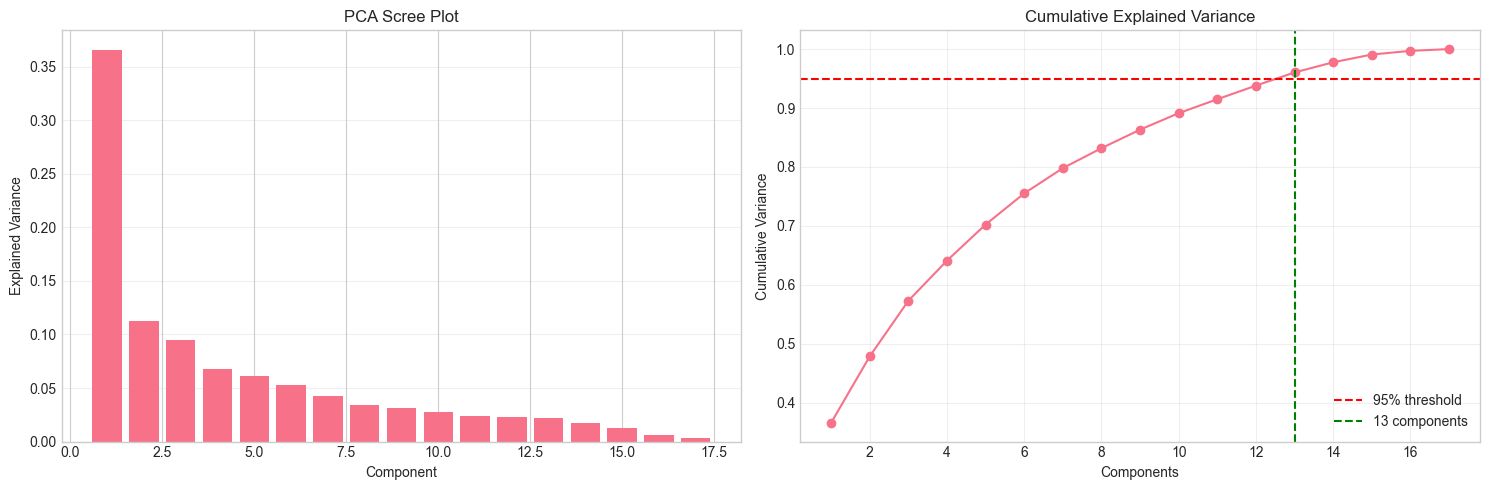

In [16]:
# CELL 12: PCA

print("Applying PCA...")

pca = PCA(random_state=RANDOM_SEED)
X_train_pca = pca.fit_transform(X_train_balanced)
X_test_pca = pca.transform(X_test_scaled)

explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

n_comp_95 = np.argmax(cumulative_var >= 0.95) + 1

print(f"Original features: {X_train_balanced.shape[1]}")
print(f"Components for 95% variance: {n_comp_95}")
print(f"Reduction: {(1 - n_comp_95/X_train_balanced.shape[1])*100:.1f}%")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].bar(range(1, min(21, len(explained_var)+1)), explained_var[:20])
axes[0].set_xlabel('Component')
axes[0].set_ylabel('Explained Variance')
axes[0].set_title('PCA Scree Plot')
axes[0].grid(axis='y', alpha=0.3)

axes[1].plot(range(1, len(cumulative_var)+1), cumulative_var, marker='o')
axes[1].axhline(0.95, color='red', linestyle='--', label='95% threshold')
axes[1].axvline(n_comp_95, color='green', linestyle='--', label=f'{n_comp_95} components')
axes[1].set_xlabel('Components')
axes[1].set_ylabel('Cumulative Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
# CELL 13: Logistic Regression

print("Training Logistic Regression...")

lr_model = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)
lr_model.fit(X_train_balanced, y_train_balanced)

y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

lr_metrics = {
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'Precision': precision_score(y_test, y_pred_lr),
    'Recall': recall_score(y_test, y_pred_lr),
    'F1-Score': f1_score(y_test, y_pred_lr),
    'AUC-ROC': roc_auc_score(y_test, y_pred_proba_lr)
}

print("\nLogistic Regression:")
for k, v in list(lr_metrics.items())[1:]:
    print(f"  {k}: {v:.4f}")

Training Logistic Regression...

Logistic Regression:
  Accuracy: 0.9755
  Precision: 0.7428
  Recall: 0.9681
  F1-Score: 0.8406
  AUC-ROC: 0.9960


In [18]:
# CELL 14: Random Forest

print("Training Random Forest...")

rf_model = RandomForestClassifier(
    n_estimators=200, max_depth=15, random_state=RANDOM_SEED, n_jobs=-1
)
rf_model.fit(X_train_balanced, y_train_balanced)

y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

rf_metrics = {
    'Model': 'Random Forest',
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1-Score': f1_score(y_test, y_pred_rf),
    'AUC-ROC': roc_auc_score(y_test, y_pred_proba_rf)
}

print("\nRandom Forest:")
for k, v in list(rf_metrics.items())[1:]:
    print(f"  {k}: {v:.4f}")

Training Random Forest...

Random Forest:
  Accuracy: 0.9836
  Precision: 0.8349
  Recall: 0.9406
  F1-Score: 0.8846
  AUC-ROC: 0.9957


In [19]:
# CELL 15: KNN

print("Training KNN...")

knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_model.fit(X_train_balanced, y_train_balanced)

y_pred_knn = knn_model.predict(X_test_scaled)
y_pred_proba_knn = knn_model.predict_proba(X_test_scaled)[:, 1]

knn_metrics = {
    'Model': 'KNN',
    'Accuracy': accuracy_score(y_test, y_pred_knn),
    'Precision': precision_score(y_test, y_pred_knn),
    'Recall': recall_score(y_test, y_pred_knn),
    'F1-Score': f1_score(y_test, y_pred_knn),
    'AUC-ROC': roc_auc_score(y_test, y_pred_proba_knn)
}

print("\nKNN:")
for k, v in list(knn_metrics.items())[1:]:
    print(f"  {k}: {v:.4f}")

Training KNN...

KNN:
  Accuracy: 0.9709
  Precision: 0.7163
  Recall: 0.9342
  F1-Score: 0.8108
  AUC-ROC: 0.9748


In [20]:
# CELL 16: XGBoost

print("Training XGBoost...")

scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.05,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_SEED,
    eval_metric='logloss',
    use_label_encoder=False,
    n_jobs=-1
)
xgb_model.fit(X_train_scaled, y_train, verbose=False)

y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

xgb_metrics = {
    'Model': 'XGBoost',
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb),
    'Recall': recall_score(y_test, y_pred_xgb),
    'F1-Score': f1_score(y_test, y_pred_xgb),
    'AUC-ROC': roc_auc_score(y_test, y_pred_proba_xgb)
}

print("\nXGBoost:")
for k, v in list(xgb_metrics.items())[1:]:
    print(f"  {k}: {v:.4f}")

Training XGBoost...

XGBoost:
  Accuracy: 0.9848
  Precision: 0.8504
  Recall: 0.9382
  F1-Score: 0.8921
  AUC-ROC: 0.9957



Model Comparison:
              Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
Logistic Regression  0.975467   0.742824 0.968080  0.840624 0.996031
      Random Forest  0.983600   0.834883 0.940648  0.884615 0.995656
                KNN  0.970867   0.716252 0.934165  0.810823 0.974783
            XGBoost  0.984833   0.850362 0.938155  0.892103 0.995664

Best Model: Logistic Regression (AUC: 0.9960)


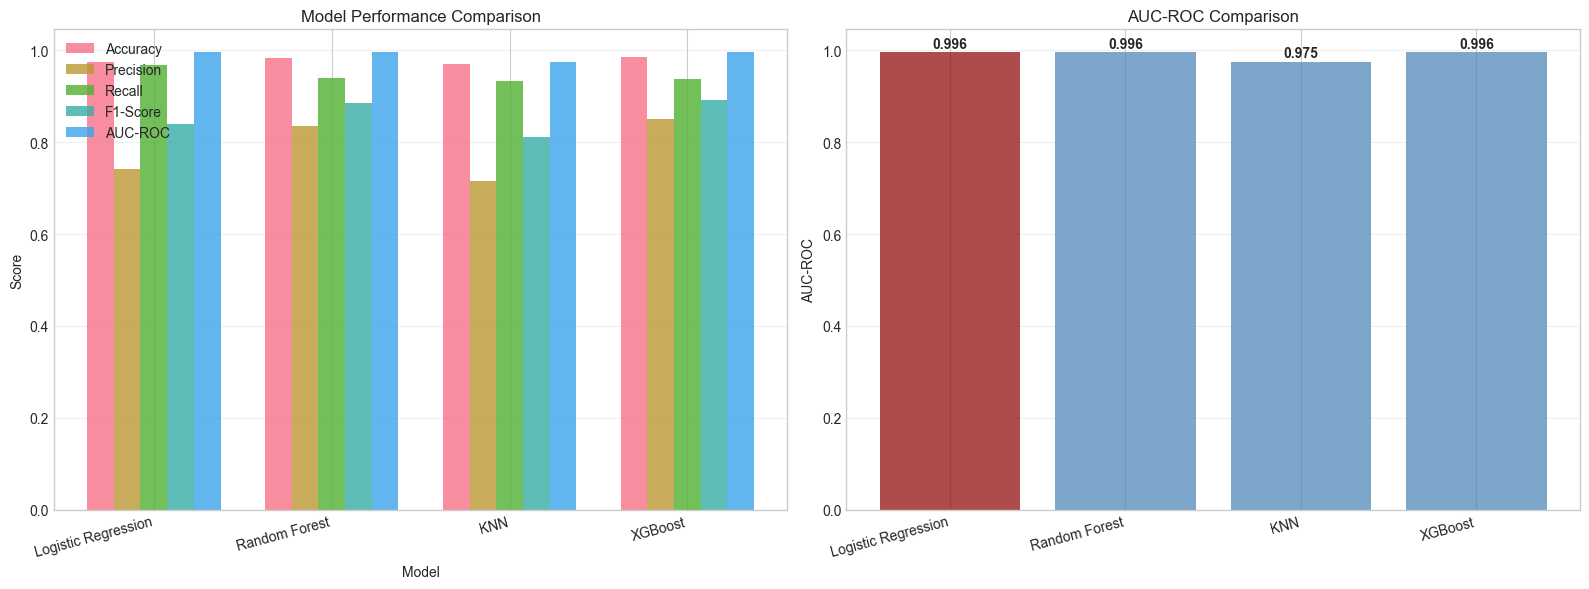

In [21]:
# CELL 17: Model Comparison

results_df = pd.DataFrame([lr_metrics, rf_metrics, knn_metrics, xgb_metrics])

print("\nModel Comparison:")
print(results_df.to_string(index=False))

best_idx = results_df['AUC-ROC'].idxmax()
print(f"\nBest Model: {results_df.loc[best_idx, 'Model']} (AUC: {results_df.loc[best_idx, 'AUC-ROC']:.4f})")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
x = np.arange(len(results_df))
width = 0.15

for i, metric in enumerate(metrics):
    axes[0].bar(x + i*width, results_df[metric], width, label=metric, alpha=0.8)

axes[0].set_xlabel('Model')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison')
axes[0].set_xticks(x + width*2)
axes[0].set_xticklabels(results_df['Model'], rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

colors = ['darkred' if i==best_idx else 'steelblue' for i in range(len(results_df))]
axes[1].bar(results_df['Model'], results_df['AUC-ROC'], color=colors, alpha=0.7)
axes[1].set_ylabel('AUC-ROC')
axes[1].set_title('AUC-ROC Comparison')
axes[1].set_xticklabels(results_df['Model'], rotation=15, ha='right')
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(results_df['AUC-ROC']):
    axes[1].text(i, v+0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

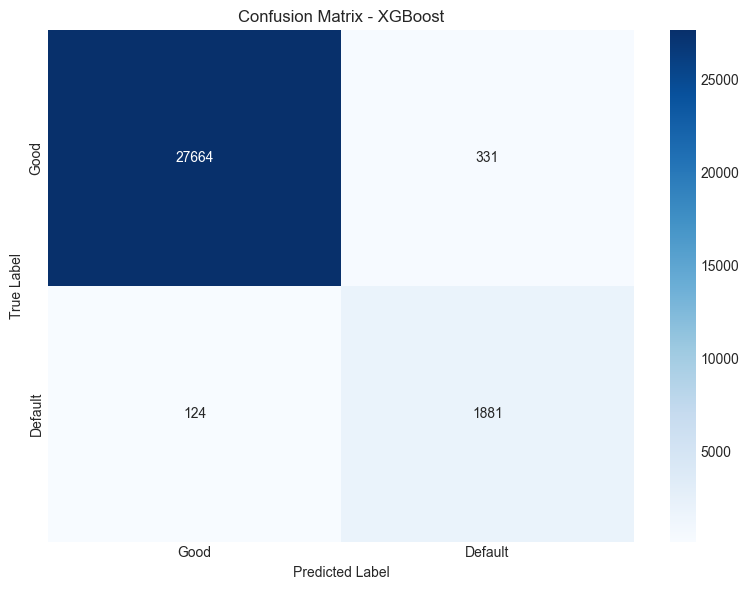


Classification Report:
              precision    recall  f1-score   support

        Good       1.00      0.99      0.99     27995
     Default       0.85      0.94      0.89      2005

    accuracy                           0.98     30000
   macro avg       0.92      0.96      0.94     30000
weighted avg       0.99      0.98      0.99     30000



In [22]:
# CELL 18: Confusion Matrix

cm = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Good', 'Default'], 
            yticklabels=['Good', 'Default'])
plt.title('Confusion Matrix - XGBoost')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, 
                            target_names=['Good', 'Default']))

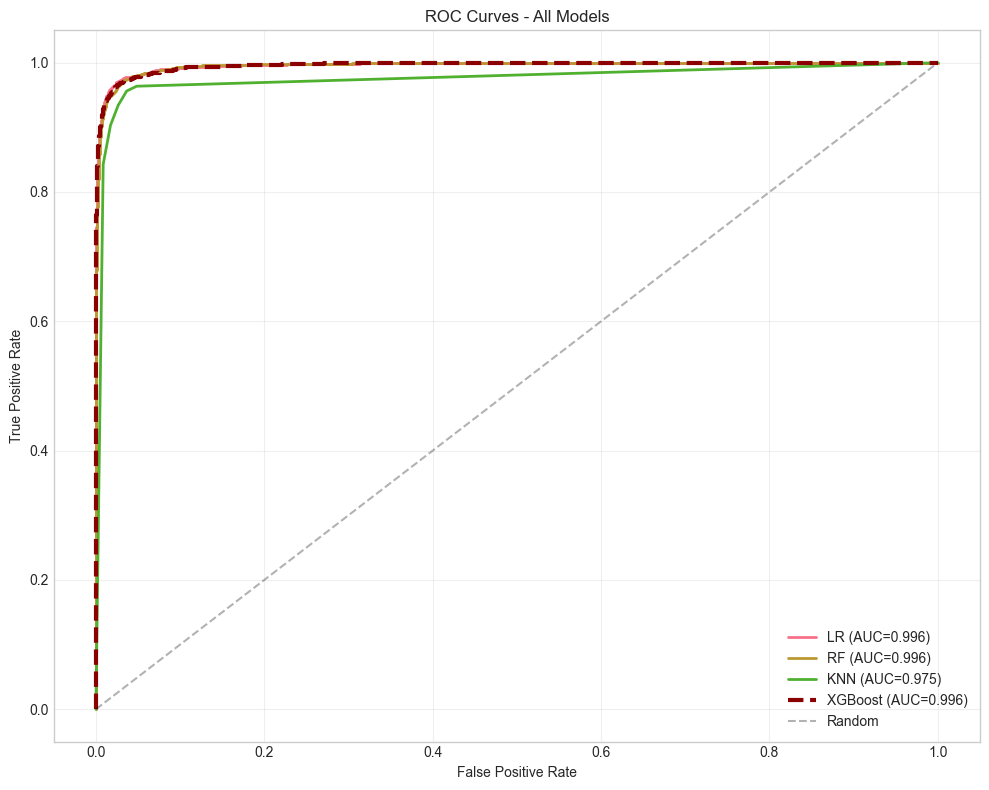

In [23]:
# CELL 19: ROC Curves

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_proba_knn)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

plt.figure(figsize=(10, 8))

plt.plot(fpr_lr, tpr_lr, linewidth=2, label=f'LR (AUC={lr_metrics["AUC-ROC"]:.3f})')
plt.plot(fpr_rf, tpr_rf, linewidth=2, label=f'RF (AUC={rf_metrics["AUC-ROC"]:.3f})')
plt.plot(fpr_knn, tpr_knn, linewidth=2, label=f'KNN (AUC={knn_metrics["AUC-ROC"]:.3f})')
plt.plot(fpr_xgb, tpr_xgb, linewidth=3, linestyle='--', 
         label=f'XGBoost (AUC={xgb_metrics["AUC-ROC"]:.3f})', color='darkred')
plt.plot([0,1], [0,1], 'k--', alpha=0.3, label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - All Models')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Top 15 Features:
                             feature  importance
                 payment_consistency    0.427684
               utility_payment_score    0.178453
                 total_late_payments    0.101035
                      savings_buffer    0.067770
               digital_payment_years    0.041098
             NumberOfTimes90DaysLate    0.040240
RevolvingUtilizationOfUnsecuredLines    0.025769
                    high_utilization    0.023681
        NumberRealEstateLoansOrLines    0.014529
NumberOfTime60-89DaysPastDueNotWorse    0.013368
NumberOfTime30-59DaysPastDueNotWorse    0.011286
                                 age    0.010845
     NumberOfOpenCreditLinesAndLoans    0.010497
                       MonthlyIncome    0.010074
                           DebtRatio    0.009389


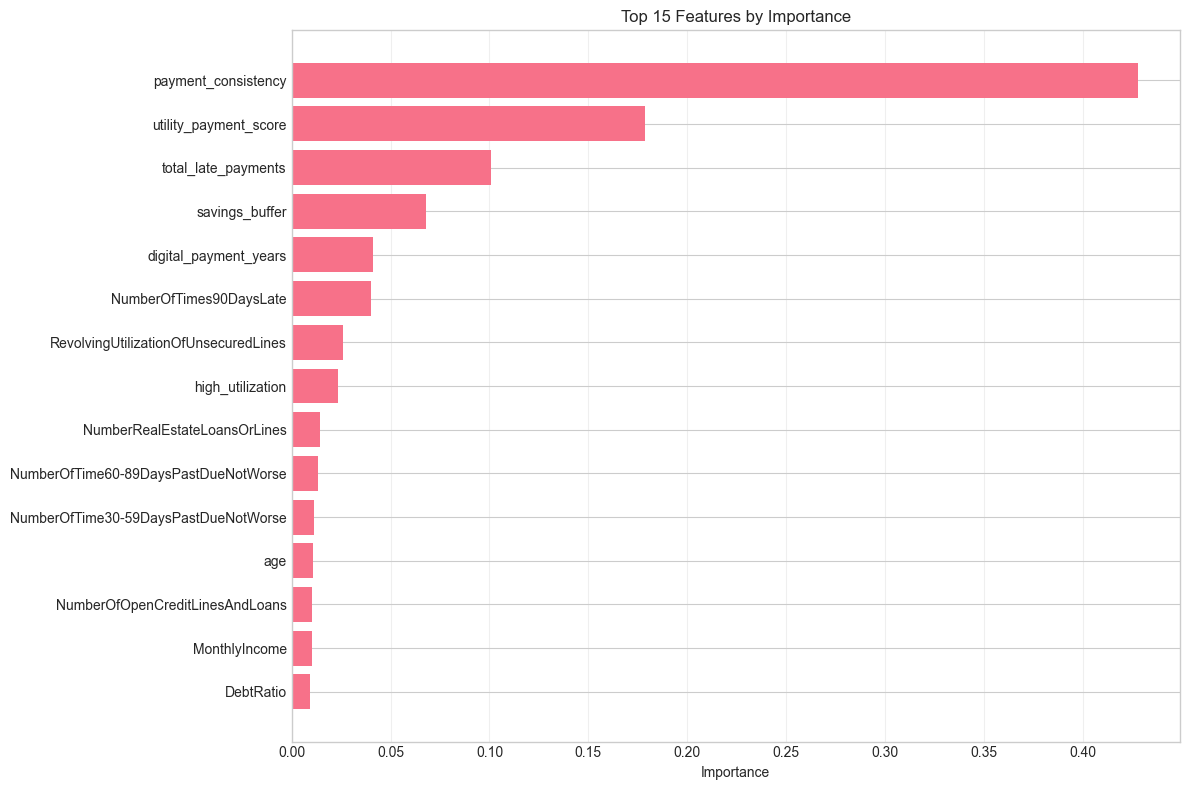

In [24]:
# CELL 20: Feature Importance

feat_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Features:")
print(feat_imp.head(15).to_string(index=False))

plt.figure(figsize=(12, 8))
top15 = feat_imp.head(15)
plt.barh(range(len(top15)), top15['importance'].values)
plt.yticks(range(len(top15)), top15['feature'].values)
plt.xlabel('Importance')
plt.title('Top 15 Features by Importance')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

Calculating SHAP values...
SHAP calculated for 1000 samples


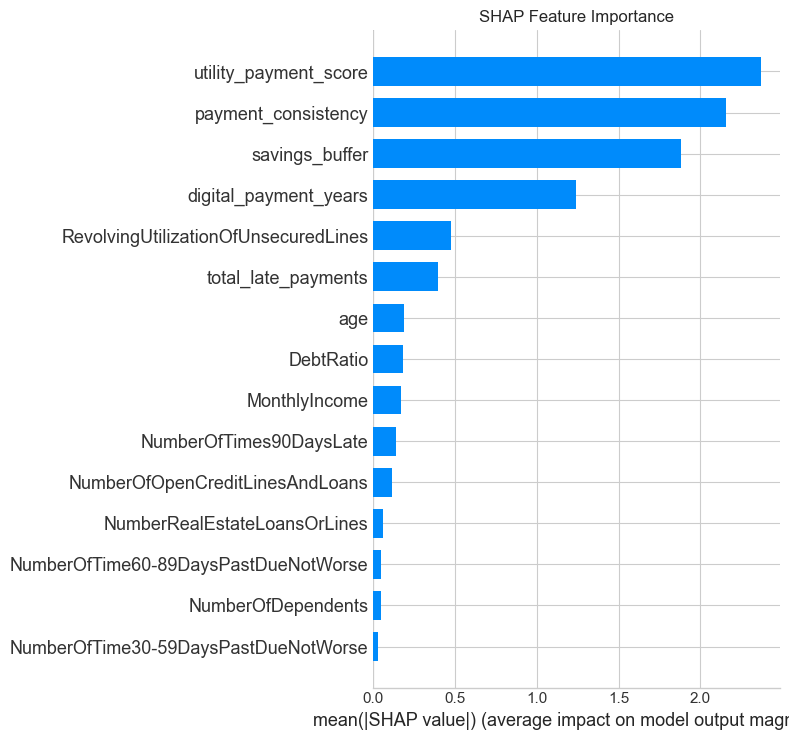

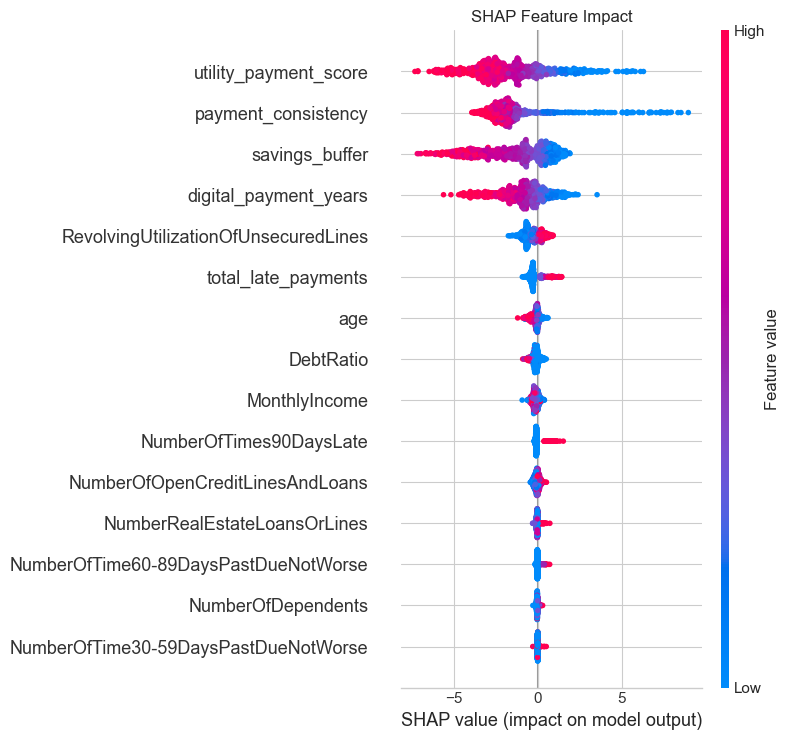

In [26]:
# CELL 21: SHAP Analysis

print("Calculating SHAP values...")

explainer = shap.TreeExplainer(xgb_model)
sample_size = min(1000, len(X_test_scaled))
X_sample = X_test_scaled.sample(sample_size, random_state=RANDOM_SEED)
shap_values = explainer.shap_values(X_sample)

print(f"SHAP calculated for {sample_size} samples")

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False, max_display=15)
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, show=False, max_display=15)
plt.title('SHAP Feature Impact')
plt.tight_layout()
plt.show()

In [27]:
# CELL 22: Final Summary

print("\nFINAL SUMMARY")
print("\nProject: Alternative Credit Scoring System")
print("Dataset: Give Me Some Credit (Kaggle)")
print(f"\nDataset Size: {len(df):,} samples")
print(f"Features: {X.shape[1]}")
print(f"Default Rate: {y.mean():.2%}")

print(f"\nBest Model: {results_df.loc[best_idx, 'Model']}")
print("\nFinal Metrics:")
for k, v in list(xgb_metrics.items())[1:]:
    print(f"  {k}: {v:.4f}")

print("\nTechniques Applied:")
print("  - SMOTE for imbalance")
print(f"  - PCA ({n_comp_95} components)")
print("  - Feature engineering")
print("  - 4 ML algorithms")
print("  - SHAP explainability")

print("\nNotebook complete")


FINAL SUMMARY

Project: Alternative Credit Scoring System
Dataset: Give Me Some Credit (Kaggle)

Dataset Size: 150,000 samples
Features: 17
Default Rate: 6.68%

Best Model: Logistic Regression

Final Metrics:
  Accuracy: 0.9848
  Precision: 0.8504
  Recall: 0.9382
  F1-Score: 0.8921
  AUC-ROC: 0.9957

Techniques Applied:
  - SMOTE for imbalance
  - PCA (13 components)
  - Feature engineering
  - 4 ML algorithms
  - SHAP explainability

Notebook complete
